In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

In [ ]:
#hide
from dolfin import *
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import matplotlib.cm as cm
# plt.rcParams['figure.figsize'] = (10,6)
# import required functions from oneDim
from statFEM.oneDim import mean_assembler, kernMat, cov_assembler, sample_gp, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler
from scipy.stats import linregress
from scipy import integrate
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

In [ ]:
from statFEM.maxDist import wass

# Get samples from statFEM prior first

In [ ]:
# set up kernel functions for forcing f
# l_f = 0.4
l_f = 0.01
σ_f = 0.1
# σ_f = 1

def m_f(x):
    return 1.0

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# # true prior solution mean
# μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)

In [ ]:
# set up true prior cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

In [ ]:
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

In [ ]:
# create statFEM sampler function
def statFEM_sampler(n_sim, grid, h, f_bar, k_f, par = False, trans = True, tol=1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))

    # get statFEM mean function
    μ_func = mean_assembler(h, f_bar)
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM cov mat on grid
    Σ = cov_assembler(J, k_f, grid, parallel=par, translation_inv=trans)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

In [ ]:
%%time
n_sim = 100
N = 41
grid = np.linspace(0,1,N)
h = 0.01
f_bar = Constant(1.0)
np.random.seed(2123)
sim_prior = statFEM_sampler(n_sim, grid, h, f_bar, k_f)

CPU times: user 53.1 ms, sys: 36.7 ms, total: 89.8 ms
Wall time: 39.7 ms


# Now get samples from statFEM posterior

In [ ]:
def statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat, par = False, trans = True, tol = 1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))
    
    # get statFEM posterior mean function
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ_func = MyExpression()
    μ_func.f = m_post_fem
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM posterior cov mat on grid
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

### Get variance info for prior

In [ ]:
pd.DataFrame(sim_prior.std(axis=1)).describe()

,0
count,41.000000
mean,0.001482
std,0.000730
min,0.000030
25%,0.000963
50%,0.001673
75%,0.002151
max,0.002321


In [ ]:
s = 10 # number of sensors
# create sensor grid (???do we need to reverse???)
Y = np.linspace(0.01,0.99,s)[::-1] 
# get true prior covariance on sensor grid
C_true_s = kernMat(c_u,Y.flatten())
# create function to compute vector mentioned above
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])

# sensor noise level
ϵ = 0.0001
np.random.seed(235)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=300)

# # get true B mat required for posterior
# B_true = (ϵ**2)*np.eye(s) + C_true_s

# # set up true posterior mean
# def true_mean(x):
#     return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
# # μ_true_s = MyExpression()
# # μ_true_s.f = true_mean
# # set up true posterior covariance
# def c_post_true(x,y):
#     return c_post(x,y,c_u,Y,B_true)

In [ ]:
%%time
np.random.seed(3542)
sim_posterior = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)

CPU times: user 77.3 ms, sys: 4.82 ms, total: 82.1 ms
Wall time: 71.2 ms


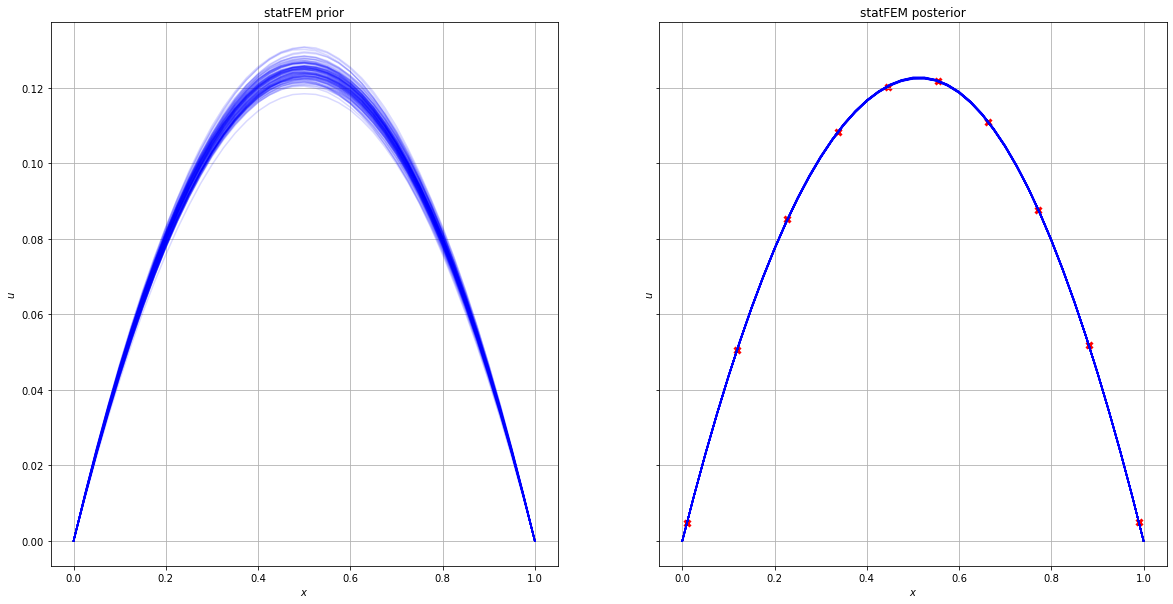

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True,sharey=True)

ax1.plot(grid,sim_prior,c='blue',alpha=0.15)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.set_title('statFEM prior')
ax1.grid()

ax2.plot(grid,sim_posterior,c='blue',alpha=0.15)
ax2.scatter(Y,v_dat,c='red',marker='x',lw=3)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u$')
ax2.set_title('statFEM posterior')
ax2.grid()